In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def sinspike(vbar, deltav, s):
    '''generate vel profile with sin spike in the center'''
    v_c = (vbar - 2 * deltav * s) / (1 - s)
    return np.piecewise(x,
                        [x < (0.5 - s / 2), (((0.5 - s / 2) <= x) & (x < (0.5 + s / 2))), (0.5 + s / 2) <= x],
                        [v_c, lambda x: -np.sin((x - 0.5 + s / 2) / s * np.pi) * deltav + v_c, v_c])


def strat_poly_normalised(irradiance, c, v_bar, n=1):
    # c: scalar proportion
    residual = (irradiance - np.mean(irradiance))
    residual = abs(residual ** n) * np.sign(residual)
    adj = (residual / max(residual)) * c
    vel = v_bar - np.mean(adj) + adj
    return vel

def strat_poly(irradiance,  v_bar, c,n=1):
    # c: scalar proportion
    residual = (irradiance - np.mean(irradiance))
    residual = abs(residual ** n) * np.sign(residual)
    adj = (residual) * c
    vel = v_bar - np.mean(adj) + adj
    return vel

def strat_exp(irradiance, c, v_bar, n=1):
    residual = (irradiance ** n - np.mean(irradiance ** n))
    adj = np.exp(residual / max(residual))
    adj = adj - np.mean(adj)
    adj = (adj) / min(adj) * -c
    vel = v_bar + adj
    return vel


def cal_e_dt(power,t):
    return np.trapz(power,x=t)

def cal_e_dx(power, velocity,x):
    return np.trapz(power / velocity,x=x)

def cal_drag_eout(velocity,x):
    return np.trapz(0.5*1.225*0.108*velocity**2,x)

1.0658141036401503e-14
1.0658141036401503e-14


<AxesSubplot:title={'center':'Net energy'}, xlabel='Vstd', ylabel='Enet'>

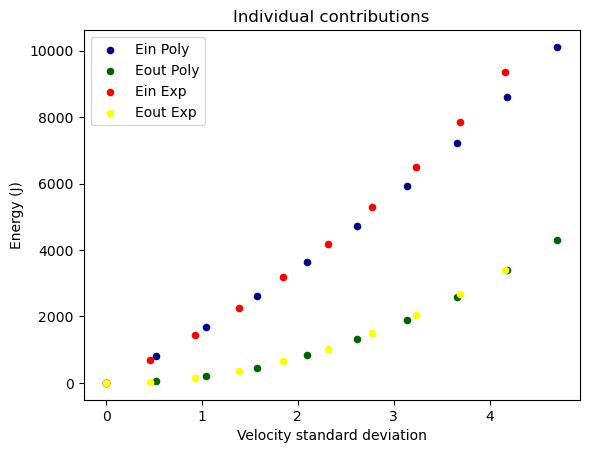

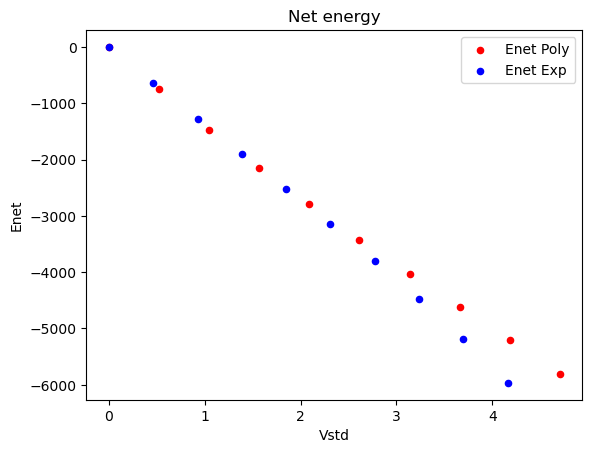

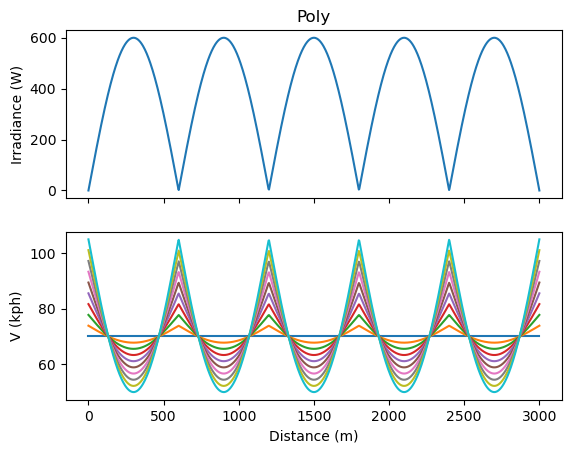

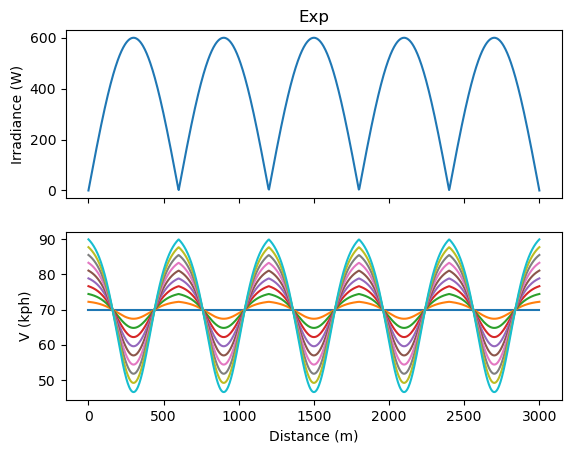

In [15]:
L = 3000
npoint = 1000
x = np.linspace(0, L, num=npoint)

### Sin irradiance distribution
I_max = 600
irradiance = abs(I_max*np.sin(x*5/L*np.pi))
## add random cloud coverage
# irradiance = irradiance + np.random.rand(npoint) * 500

### Stepped irradiance distribution
# I_bar = 600
# i = 400
# L = 3000
# npoint = 1000
# x = np.linspace(0, L, num=npoint)
# irradiance = np.piecewise(x, [x < L / 2, x >= L / 2], [lambda x: I_bar + i, lambda x: I_bar - i])

irradiance[irradiance < 0] = 0
v_bar = 70 / 3.6
dVel = 20 / 3.6
Estdfig, estdax = plt.subplots(1)
Enetfig, enetax = plt.subplots(1)
estdax.set(title='Individual contributions')
enetax.set(title='Net energy')

linfig, linax = plt.subplots(2, sharex=True)
linax[0].plot(x, irradiance)
linax[0].set(ylabel='Irradiance (W)', title='Poly')

estd = []
for j, axes in enumerate(linax[1:]):
    j += 1
    for i in np.linspace(0, -dVel, num=10):
        vel = strat_poly_normalised(irradiance, i, v_bar, j)
        axes.plot(x, vel * 3.6)
        axes.set(ylabel='V (kph)')
        itr = [cal_e_dx(irradiance, vel,x), cal_drag_eout(vel,x), np.std(vel)]
        estd.append(itr)
        # print(np.mean(vel))
# print(estd)
axes.set(xlabel='Distance (m)')

df = pd.DataFrame(estd)
df.columns = ['Ein', 'Eout', 'Vstd']
df.loc[:, 'Eout'] = df['Eout'] - df['Eout'].iloc[0]
df.loc[:, 'Ein'] = df['Ein'] - df['Ein'].iloc[0]  # make it delta to baseline
df.plot.scatter(y="Ein", x="Vstd", color="DarkBlue", label="Ein Poly", ax=estdax)
df.plot.scatter(y="Eout", x="Vstd", color="DarkGreen", label="Eout Poly", ax=estdax)
estdax.set(xlabel='Velocity standard deviation', ylabel='Energy (J)')
df.loc[:, 'Enet'] =  df['Eout'] - df['Ein']
Enetarray = df['Enet'].to_numpy()
print(maxstd := df['Vstd'].to_numpy()[np.argmax(Enetarray)])
df.plot.scatter(y='Enet', x='Vstd', ax=enetax, label="Enet Poly", color="Red")

expfig, expax = plt.subplots(2, sharex=True)
expax[0].plot(x, irradiance)
expax[0].set(ylabel='Irradiance (W)', title='Exp')

estd = []
for j, axes in enumerate(expax[1:]):
    j += 1
    for i in np.linspace(0, -dVel, num=10):
        vel = strat_exp(irradiance, i, v_bar, j)
        axes.plot(x, vel * 3.6)
        axes.set(ylabel='V (kph)')
        itr = [cal_e_dx(irradiance, vel,x), cal_drag_eout(vel,x), np.std(vel)]
        estd.append(itr)
        # print(np.mean(vel))
# print(estd)
axes.set(xlabel='Distance (m)')
df = pd.DataFrame(estd)
df.columns = ['Ein', 'Eout', 'Vstd']
df.loc[:, 'Eout'] = df['Eout'] - df['Eout'].iloc[0]
df.loc[:, 'Ein'] = df['Ein'] - df['Ein'].iloc[0]  # make it delta to baseline
df.plot.scatter(y="Ein", x="Vstd", color="Red", label="Ein Exp", ax=estdax)
df.plot.scatter(y="Eout", x="Vstd", color="Yellow", label="Eout Exp", ax=estdax)
estdax.set(xlabel='Velocity standard deviation', ylabel='Energy (J)')
df.loc[:, 'Enet'] =  df['Eout'] - df['Ein']
Enetarray = df['Enet'].to_numpy()
print(maxstd := df['Vstd'].to_numpy()[np.argmax(Enetarray)])
df.plot.scatter(y='Enet', x='Vstd', ax=enetax, label="Enet Exp", color="Blue")


In [21]:
### stepped irradiance distribution
I_bar = 1000*0.2
i = 1000
L = 3000
npoint = 20
x = np.linspace(0, L, num=npoint)
irradiance = np.piecewise(x, [x < L / 2, x >= L / 2], [lambda x: I_bar + i, lambda x: I_bar - i])
v_bar = 70 / 3.6

In [22]:
c = 0.001
I_prime = irradiance - I_bar
v_prime = -c*I_prime
vel = v_bar+v_prime
vel = strat_poly(irradiance,v_bar,-c,1)

In [23]:
cal_e_dx(irradiance,vel,x)

38894.70927187007

In [24]:
cal_drag_eout(vel,x) - cal_drag_eout(vel*0+v_bar,x)

198.44999999998254

In [25]:
L*(I_bar*v_bar+c*(i**2))/(v_bar**2-(c**2)*(i**2))

38894.709271870095

In [26]:
v_prime[0]

-1.0